# Learnsync ML use case implementation (Simulation version)

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from matplotlib_venn import venn3
from scipy.stats import shapiro
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## 1. Prepare data source
- The original dataset we chose from [Time Management and Productivity Insights](https://www.kaggle.com/datasets/hanaksoy/time-management-and-productivity-insights/data) is fictitious and does not contain relationships between the independent features and the Productivity Level which is needed for the use case. Thus we decide to add some generated data to match our ML use cases: `Showing other similar learners` and `Providing time management tips and learning strategies`.
- The columns in our generated dataset are consistent with the original dataset.

### Generate new data

In [98]:
def gen_dataset(n_samples=500):
    """
    Input: sample numbers
    Output: dataset in pd.DataFrame format

    Assumption:
    - Factors with positive relationship to productivity:
        daily_work_hours, daily_sleep_hours, exercise_hours, daily_leisure_hours
    - Factors with negative relationship to productivity:
        commute_time, screen_time, age

    The productivity score is generated using a weighted sum of features.
    Each weight reflects how strongly that factor is assumed to influence productivity.
    A small amount of random noise is added to simulate real-world unpredictability.
    """
    import numpy as np
    import pandas as pd

    np.random.seed(42)

    # Generate features
    user_id = np.arange(1, n_samples + 1)
    age = np.random.randint(20, 60, size=n_samples)
    daily_work_hours = np.random.uniform(4, 10, size=n_samples)
    daily_work_hours = np.round(daily_work_hours, 2)

    daily_leisure_hours = np.random.uniform(0.5, 5, size=n_samples)
    daily_leisure_hours = np.round(daily_leisure_hours, 2)

    daily_exercise_minutes = np.random.randint(0, 120, size=n_samples)

    daily_sleep_hours = np.random.uniform(5, 9, size=n_samples)
    daily_sleep_hours = np.round(daily_sleep_hours, 2)

    screen_time = np.random.uniform(1, 6, size=n_samples)
    screen_time = np.round(screen_time, 2)

    commute_time = np.random.uniform(0, 2, size=n_samples)
    commute_time = np.round(commute_time, 2)

    # Convert exercise time to hours
    exercise_hours = daily_exercise_minutes / 60.0

    # Assume the productivity score follows a realistic pattern:
    productivity_score = (
        1.5 * daily_work_hours           # More work hours can increase productivity
        + 1.0 * daily_sleep_hours        # Better sleep supports better focus and output
        + 0.8 * exercise_hours           # Physical activity improves energy and alertness
        + 0.4 * daily_leisure_hours      # Moderate leisure helps reduce stress
        - 0.6 * commute_time             # Longer commutes reduce time and energy for work
        - 0.05 * age                     # Slight decline in productivity with age
        - 0.2 * screen_time              # Excessive screen time may distract or tire users
        + np.random.normal(0, 2, size=n_samples)  # Add some noise to mimic real-life variance
    )
    productivity_score = productivity_score.astype(int)

    # Clip productivity score to 0–100 range
    productivity_score = np.clip(productivity_score, 0, 100)

    # Create the final DataFrame
    df = pd.DataFrame({
        'User ID': user_id,
        'Age': age,
        'Daily Work Hours': daily_work_hours,
        'Daily Leisure Hours': daily_leisure_hours,
        'Daily Exercise Minutes': daily_exercise_minutes,
        'Daily Sleep Hours': daily_sleep_hours,
        'Screen Time (hours)': screen_time,
        'Commute Time (hours)': commute_time,
        'Productivity Score': productivity_score
    })

    return df

gen_data = gen_dataset(n_samples=10000)
print(f"Generate {gen_data.shape[0]} data. \nShape of dataframe: {gen_data.shape}.")
display(gen_data.head(5))

Generate 10000 data. 
Shape of dataframe: (10000, 9).


,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Screen Time (hours),Commute Time (hours),Productivity Score
0,1,58,8.41,3.18,86,8.85,5.98,1.61,17
1,2,48,5.82,2.80,45,6.84,4.34,0.89,11
2,3,34,6.07,0.52,82,6.29,1.37,0.55,15
3,4,27,9.95,3.00,25,6.19,5.01,0.84,23
4,5,40,4.61,4.70,49,5.17,4.75,0.85,9


### Store dataframe into csv file.

In [83]:
# Save the generated dataset to a CSV file
path = "../data/synthetic_productivity_dataset.csv"
gen_data.to_csv(path, index=False)
print(f"Dataset saved as {path}")

Dataset saved as ../data/synthetic_productivity_dataset.csv


### Merge the origina and new dataset together

In [84]:
# # Load new data
path = "../data/synthetic_productivity_dataset.csv"
gen_data = pd.read_csv(path)
print(f"The new data contains {gen_data.shape[0]} samples.")

# # Load original data
origin_path = "../data/Time Management and Productivity Insights.csv"
origin_data = pd.read_csv(origin_path)
print(f"Origin data contains {origin_data.shape[0]} samples.")
display(origin_data.dtypes)

# # Merge new and origina data
merged_data = pd.concat([new_data, origin_data], ignore_index=True)
print(f"The merged data contains {merged_data.shape[0]} samples.")

# # Save the merged dataset to a CSV file
path = "../data/merged.csv"
merged_data.to_csv(path, index=False)
print(f"Merged dataframe have been saved as {path}.")

The new data contains 10000 samples.
Origin data contains 85 samples.


User ID                     int64
Age                         int64
Daily Work Hours          float64
Daily Leisure Hours       float64
Daily Exercise Minutes      int64
Daily Sleep Hours         float64
Productivity Score          int64
Screen Time (hours)       float64
Commute Time (hours)      float64
dtype: object

The merged data contains 10085 samples.
Merged dataframe have been saved as ../data/merged.csv.


### Load `merged` dataset from csv file.

In [37]:
# Load new data
path = "../data/synthetic_productivity_dataset.csv"
data = pd.read_csv(path)
print(f"The dataset contains {data.shape[0]} samples. Shape: {data.shape}")

data.describe().T.round(3)

The dataset contains 1000 samples. Shape: (1000, 9)


,count,mean,std,min,25%,50%,75%,max
User ID,1000.0,500.500,288.819,1.000,250.750,500.500,750.250,1000.000
Age,1000.0,39.991,11.780,20.000,30.000,41.000,50.250,59.000
Daily Work Hours,1000.0,7.019,1.707,4.001,5.525,7.088,8.489,9.996
Daily Leisure Hours,1000.0,2.767,1.313,0.501,1.587,2.855,3.881,4.999
Daily Exercise Minutes,1000.0,61.762,34.053,0.053,33.502,62.560,91.554,119.945
Daily Sleep Hours,1000.0,6.928,1.172,5.001,5.921,6.877,7.971,8.990
Screen Time (hours),1000.0,3.449,1.429,1.010,2.200,3.439,4.685,5.995
Commute Time (hours),1000.0,0.994,0.575,0.001,0.511,1.007,1.460,2.000
Productivity Score,1000.0,16.149,3.730,4.761,13.548,16.257,18.890,25.896


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 1000 non-null   int64  
 1   Age                     1000 non-null   int64  
 2   Daily Work Hours        1000 non-null   float64
 3   Daily Leisure Hours     1000 non-null   float64
 4   Daily Exercise Minutes  1000 non-null   float64
 5   Daily Sleep Hours       1000 non-null   float64
 6   Screen Time (hours)     1000 non-null   float64
 7   Commute Time (hours)    1000 non-null   float64
 8   Productivity Score      1000 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 70.4 KB


### Preprocessing

In [39]:
features = data.drop('User ID', axis=1)
data = data.drop('User ID', axis=1)

X = features.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Feature Correlation Heatmap

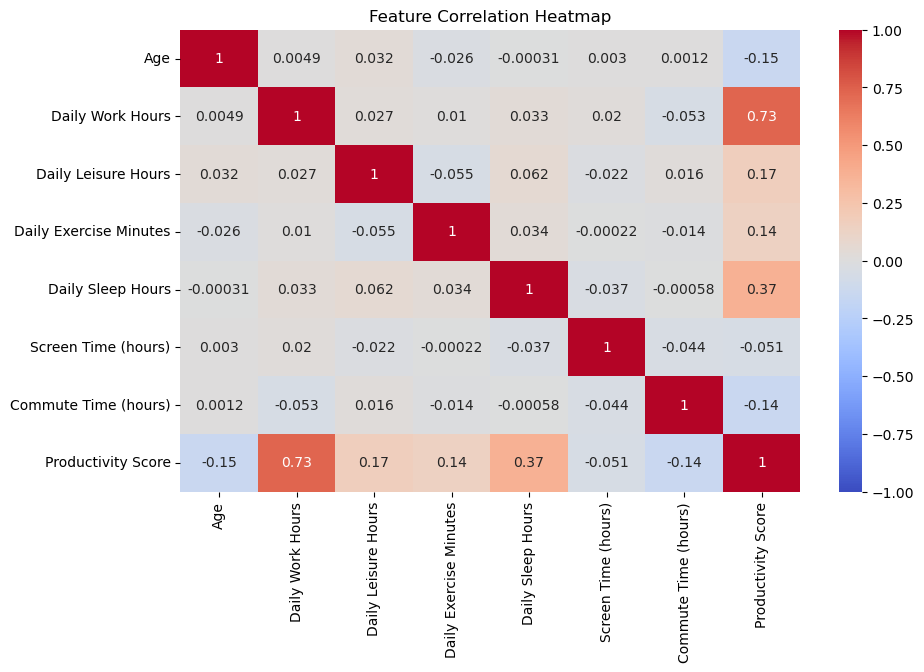

In [40]:
plt.figure(figsize=(10,6))
# sns.heatmap(data[features + ['Productivity Score']].corr(), annot=True, cmap='coolwarm')
sns.heatmap(features.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

## 2. Use case: Showing other similar learners

– About: This use case aims to cluster our users based on their time management and productivity patterns to facilitate the formation of study groups or peer networks. So that, users with similar studying habits can connect, share tips, and collaborate effectively.

– Tasks: The following section performs `K-Means clustering` to group our users.

In [41]:
wcss = []
# Elbow method (to find optimal number of K)
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

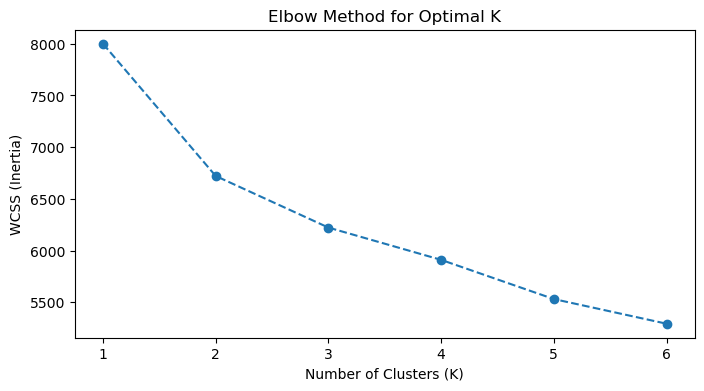

In [42]:
# Plot Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(range(1, 7), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [43]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
data['Cluster'] = clusters

c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


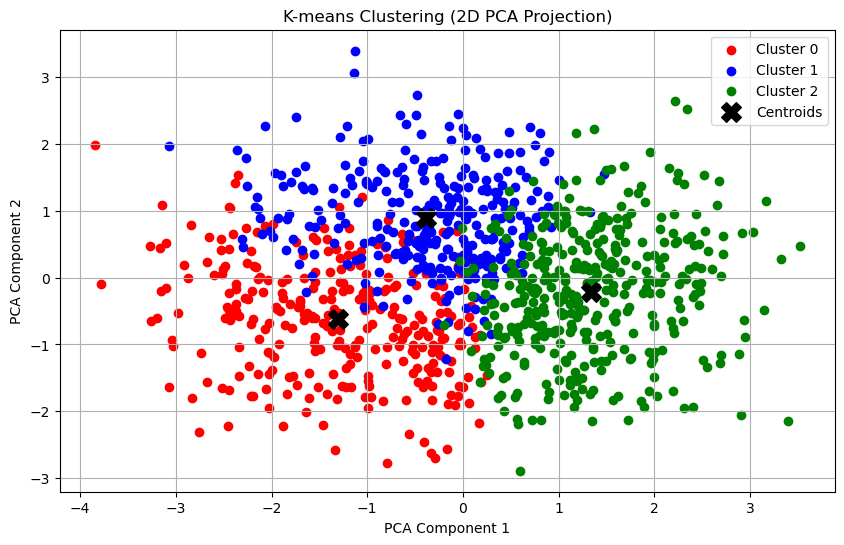

In [44]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']  # Adjust for k
for i in range(k):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], 
                c=colors[i], label=f'Cluster {i}')

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='X', s=200, c='black', label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering (2D PCA Projection)')
plt.legend()
plt.grid()
plt.show()

In [45]:
data.groupby('Cluster').mean().T.round(2)

Cluster,0,1,2
Age,40.29,41.19,38.82
Daily Work Hours,5.88,6.28,8.49
Daily Leisure Hours,1.69,3.82,2.79
Daily Exercise Minutes,67.23,47.22,68.81
Daily Sleep Hours,6.33,7.04,7.31
Screen Time (hours),3.64,3.27,3.43
Commute Time (hours),1.05,1.16,0.82
Productivity Score,12.79,15.13,19.60


## 3. Use case: Providing time management tips and learning strategies

– About: This use case aims to provide users with suggestions to improve their time management and learning strategies. Before doing so, the system will analyze key learning-related factors that may significantly influence the user's `Productivity Score`.

– Tasks: The following section performs an `MLR-OLS analysis` to identify the most important factors. Based on this analysis, a regression model will be built to predict each user's `Productivity Score`.

### Split into training and testing set

In [136]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features
sel_features = ['Age', 'Daily Work Hours', 'Daily Leisure Hours', 'Daily Exercise Minutes',
            'Daily Sleep Hours', 'Screen Time (hours)', 'Commute Time (hours)']
X = data[sel_features]
y = data['Productivity Score']

# Prepare Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Conduct Z-scaled normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit on training data
X_test_scaled = scaler.transform(X_test)         # Transform test data using training stats

### 3.1 OLS analysis

In [137]:
X = sm.add_constant(X_train_scaled) # Add intercept
model = sm.OLS(y_train, X).fit() # Build MLR model
print(model.summary()) # Print result

                            OLS Regression Results                            
Dep. Variable:     Productivity Score   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     293.4
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:50:46   Log-Likelihood:                -26290.
No. Observations:                8068   AIC:                         5.260e+04
Df Residuals:                    8060   BIC:                         5.265e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1138      0.070    229.850      0.0

### 3.2 MLR: Multi-input regression task

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create and train regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict the Productivity Score on testing set
y_pred = model.predict(X_test_scaled)

# Evluate model by testing results
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"MSE: {mse:.2f}")
print(f"R_square: {r2:.2f}")

# Print model coefficients
coefficients = pd.DataFrame({
    'Feature': sel_features,
    'Coefficient': model.coef_
})
print(coefficients.sort_values(by='Coefficient', ascending=False))

MSE: 43.08
R_square: 0.22
                  Feature  Coefficient
1        Daily Work Hours     2.585062
4       Daily Sleep Hours     1.158763
2     Daily Leisure Hours     1.143495
5     Screen Time (hours)     0.526754
3  Daily Exercise Minutes     0.484165
6    Commute Time (hours)     0.185246
0                     Age    -0.481407


## Summary
In this document, multi-linear regression model is able to predict the productivity score of the generated dataset.